**Assignment 1**\
**Mina Ilkhani**\
**610398191**

In [27]:
import numpy as np
w_reward = -1 # way reward
b_reward = -np.inf # block reward
f_reward = 30 # flag reward
t_reward = 300 # target reward
start_state = [0,0]
revisit_reward = -2 #punish revisiting a state
ACTIONS = ['up', 'down', 'left', 'right']
BLOCK_TYPES = ['w', 'b', 'f', 't', 'r']
BLOCK_REWARDS = {'w':w_reward, 'b':b_reward, 'f':f_reward, 't':t_reward}

In [28]:
BOARD = [['w', 'b', 'w', 'w', 'w' ,'w', 'w', 'w', 'w', 'w'],
         ['w', 'w', 'w', 'f', 'w', 'b', 'w', 'w', 'w', 'w'],
         ['f', 'w', 'w', 'w', 'w', 'b', 'f', 'w', 'w', 'w'],
         ['b', 'b', 'w', 'b' ,'b' ,'w' ,'b' ,'w' ,'w' ,'w'],
         ['w', 'f', 'b' ,'w' ,'b', 'f' ,'b' ,'b' ,'b' ,'w'],
         ['w', 'w' ,'b', 'w', 'b', 'w', 'w', 'w', 'w', 'w'],
         ['w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w'],
         ['w', 'f', 'w', 'w', 'w' ,'w', 'b', 'b', 'b', 'b'],
         ['w', 'b' ,'b' ,'b' ,'b', 'b' ,'w', 'w', 'w', 'w'],
         ['w', 'w', 'w', 'w', 'w', 'w', 'w', 'b', 'f', 't']
         ]


In [29]:
def get_neighbor_location(i, j, action):
    if action == 'right':
        return i, j+1
    elif action == 'left':
        return i, j-1
        
    elif action == 'up':
        return i-1, j
    
    elif action == 'down':
        return i+1, j

def isValidAction(i, j, action):
    isize = len(BOARD)
    jsize = len(BOARD[0])
    if action == 'right':
        # print(i,j, action, BOARD[i][j+1])
        if j + 1 >= jsize  :
            return False
        if BOARD[i][j+1] == 'b':
            return False

    elif action == 'left':
        if j-1 < 0 :
            return False
        if  BOARD[i][j - 1] == 'b':
            return False

    elif action == 'up':
        if i - 1 < 0 :
            return False
        if BOARD[i - 1][j] == 'b' :
            return False
    elif action == 'down':
        if i + 1 >= isize:
            return False
        if  BOARD[i + 1][j] == 'b':
            return False
    return True

initialization q_table:

In [30]:
q_table = {}
def initialization_q_table():
    for i in range(len(BOARD)):
        for j in range(len(BOARD[0])):
            if BOARD[i][j] != 'b':
                for action in ACTIONS:
                    if isValidAction(i,j, action):
                        inewState, jnewState = get_neighbor_location(i,j,action)
                        q_table[(i,j,action, BOARD[inewState][jnewState])] = BLOCK_REWARDS[BOARD[inewState][jnewState]]
                        q_table[(i,j,action, 'r')] = revisit_reward

In [31]:
EPISODS = 500
ALPHA = 1
GAMMA = 1
visited_state = []

In [32]:
from copy import deepcopy
class Environment:
    def __init__(self) :
        self.board = deepcopy(BOARD)
        self.visitedFlags = set()
        self.visitedBlocks = dict()

    def addVisited(self, i, j):
        if (i, j) in self.visitedBlocks:
            self.visitedBlocks[i, j] += 1
        else:
            self.visitedBlocks[i, j] = 1
            
        if self.board[i][j] == 'f' and (i, j) not in self.visitedFlags:
            self.visitedFlags.add((i, j))
    


In [33]:
def getReward(i,j, en:Environment):
    c = en.board[i][j]
    if c == 'f':
        return f_reward * (len(en.visitedFlags)+1)
    elif c == 't':
        return t_reward
    elif c == 'w':
        return w_reward
    if (i, j) in en.visitedBlocks: # visited
        return en.visitedBlocks[i, j] * revisit_reward

In [34]:
class State:
    def __init__(self, i, j, en: Environment):
        self.i = i
        self.j = j
        self.reward = 0
        self.en = en
    def action(self, action):
        self.i, self.j = get_neighbor_location(self.i, self.j, action)
    

In [35]:

    
import random
import numpy as np
def chooseAValidRandomNeighbor(i,j, q_table):
    while True:
        action = random.choice(ACTIONS)
        if isValidAction(i,j,action):
            return action
        action = random.choice(ACTIONS)

        
def chooseBestNeighbor(state:State, en:Environment, q_table) :
    maxQ = -np.inf
    action = ''
    for ac in ACTIONS:
        if isValidAction(state.i, state.j, ac):
            inew, jnew = get_neighbor_location(state.i, state.j, ac)
            qVal = q_table[state.i, state.j, ac, en.board[inew][jnew]]
            if maxQ < qVal :
                maxQ = qVal
                action = ac
            maxQ = max(maxQ, qVal)
    return action, maxQ
    
def chooseNeighbor(state:State, en, q_table, strategy):
    if strategy == 'explotation':
        return chooseBestNeighbor(state, en, q_table)[0]
    elif strategy == 'exploration':
        return chooseAValidRandomNeighbor(state.i,state.j, q_table)


In [36]:
class Episode:
    def __init__(self,q_table:dict) :
        self.q_table = q_table
        self.en = Environment()
        self.en.addVisited(0, 0)
        self.en.board[0][0] = 'r'
        self.state = State(0, 0, self.en)
        
    def run(self, action):
        nextState = deepcopy(self.state)
        nextState.action(action)

        oldVal = self.q_table[self.state.i, self.state.j , action, self.en.board[self.state.i][self.state.j]]
        oldType = self.en.board[nextState.i][nextState.j]

        reward = getReward(nextState.i, nextState.j, self.en)
        nextState.reward += reward

        self.en.addVisited(nextState.i, nextState.j )
        self.en.board[nextState.i][nextState.j] = 'r'

        bestQ = chooseBestNeighbor(nextState,self.en, self.q_table)

        self.q_table[self.state.i, self.state.j, action, oldType] = oldVal + ALPHA*(reward + GAMMA*bestQ[1] - oldVal)

        self.state = nextState
        return self.state.i == len(BOARD)-1 and self.state.j == len(BOARD[0])-1   

## learning:

In [37]:
def learn():
    for maxStep in range(EPISODS):
        episode = Episode(q_table)
        x,y = 0,0
        # print('episode',maxStep,":\n explotation:")
        for i in range(maxStep):
            if episode.state.reward >= -400: # min reward 
                strategy = 'explotation' if i <= maxStep//5 else 'exploration'
                action = chooseNeighbor(episode.state, episode.en, episode.q_table, strategy)
                x, y = get_neighbor_location(x,y,action) 
                if episode.run(action):
                    break
            

## Run model:

In [64]:
def run():
    en = Environment()
    state = State(0,0, en)
    en.board[state.i][state.j] = 'r'
    en.addVisited(0, 0)
    visitedFlagsCounter = 0
    for step in range(50): # if it doesn't reach gaol in less than 50 steps is it absolutely not optimal
        # print("step:", step+1)
        action, reward = chooseBestNeighbor(state, en, q_table)
        # print(state.i, state.j, action, end = ' ')

        state.action(action)
        # print(en.board[state.i][state.j])
        # print()
        if en.board[state.i][state.j] == 'f':
            visitedFlagsCounter+=1
        en.addVisited(state.i,state.j)
        en.board[state.i][state.j] = 'r'
        if state.i == len(BOARD)-1 and state.j == len(BOARD[0])-1:
            print(state.i, state.j, )
            break
    print('the last step:',state.i, state.j, )
    print('number of visited flags:', visitedFlagsCounter)

### Q-Table graph

In [52]:
import matplotlib.pyplot as plt
import networkx as nx


def plot_q_table_graph():
    fig = plt.figure(figsize=(25, 25))
    G = nx.DiGraph()
    added_edges = set()
    for key in q_table:
        i1, j1, action, blockType2 = key
        blockType1 = BOARD[i1][j1]
        i2, j2 = get_neighbor_location(i1, j1, action)
        if( ((i1, j1, blockType1) , (i2, j2, blockType2)) not in added_edges):
            G.add_edge(f"{i1},{j1},{blockType1}", f"{i2},{j2},{blockType2}", weight=int(q_table[key]))
    
        if( ((i1, j1, 'r') , (i2, j2, blockType2)) not in added_edges):
            G.add_edge(f"{i1},{j1},{blockType1}", f"{i2},{j2},{blockType2}", weight=int(q_table[key]))

    edges = [(u, v) for (u, v, d) in G.edges(data=True)]
    pos = nx.spring_layout(G) 
    
    nx.draw_networkx_nodes(G, pos, node_size=800)
    nx.draw_networkx_edges(G, pos, edgelist=edges, width=2)
    
    nx.draw_networkx_labels(G, pos, font_size=10)

    edge_labels = nx.get_edge_attributes(G, "weight")
    
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=10)
    
    ax = plt.gca()
    ax.margins(0.08)
    ax.figure.set_size_inches(30, 20)
    ax.set_facecolor("gray")
    plt.tight_layout()
    plt.show()


### Q-table:

In [40]:
from tabulate import tabulate
headers = ['i',' j', 'right', 'left', 'up', 'down']
def print_q_table():

    print(tabulate([[*key, q_table[key]] for key in q_table], headers=headers, tablefmt="fancy_grid"))

### run with different alpha and gamma

In [41]:
initialization_q_table()

In [65]:
EPISODS = 600
GAMMA = 0.25
ALPHA = 0.8
learn()
run()

the last step: 8 8
number of visited flags: 6


In [53]:
EPISODS = 600
GAMMA = 0.25
ALPHA = 1
learn()
print('============================================')
run()

step: 1
0 0 down w

step: 2
1 0 down f

step: 3
2 0 right w

step: 4
2 1 up w

step: 5
1 1 right w

step: 6
1 2 right f

step: 7
1 3 up w

step: 8
0 3 right w

step: 9
0 4 right w

step: 10
0 5 right w

step: 11
0 6 down w

step: 12
1 6 down f

step: 13
2 6 right w

step: 14
2 7 down w

step: 15
3 7 right w

step: 16
3 8 right w

step: 17
3 9 down w

step: 18
4 9 down w

step: 19
5 9 left w

step: 20
5 8 left w

step: 21
5 7 left w

step: 22
5 6 left w

step: 23
5 5 up f

step: 24
4 5 down r

step: 25
5 5 down w

step: 26
6 5 left w

step: 27
6 4 down w

step: 28
7 4 left w

step: 29
7 3 left w

step: 30
7 2 left f

step: 31
7 1 up w

step: 32
6 1 up w

step: 33
5 1 up f

step: 34
4 1 left w

step: 35
4 0 down w

step: 36
5 0 down w

step: 37
6 0 down w

step: 38
7 0 down w

step: 39
8 0 down w

step: 40
9 0 right w

step: 41
9 1 right w

step: 42
9 2 right w

step: 43
9 3 right w

step: 44
9 4 right w

step: 45
9 5 right w

step: 46
9 6 up w

step: 47
8 6 right w

step: 48
8 7 right w

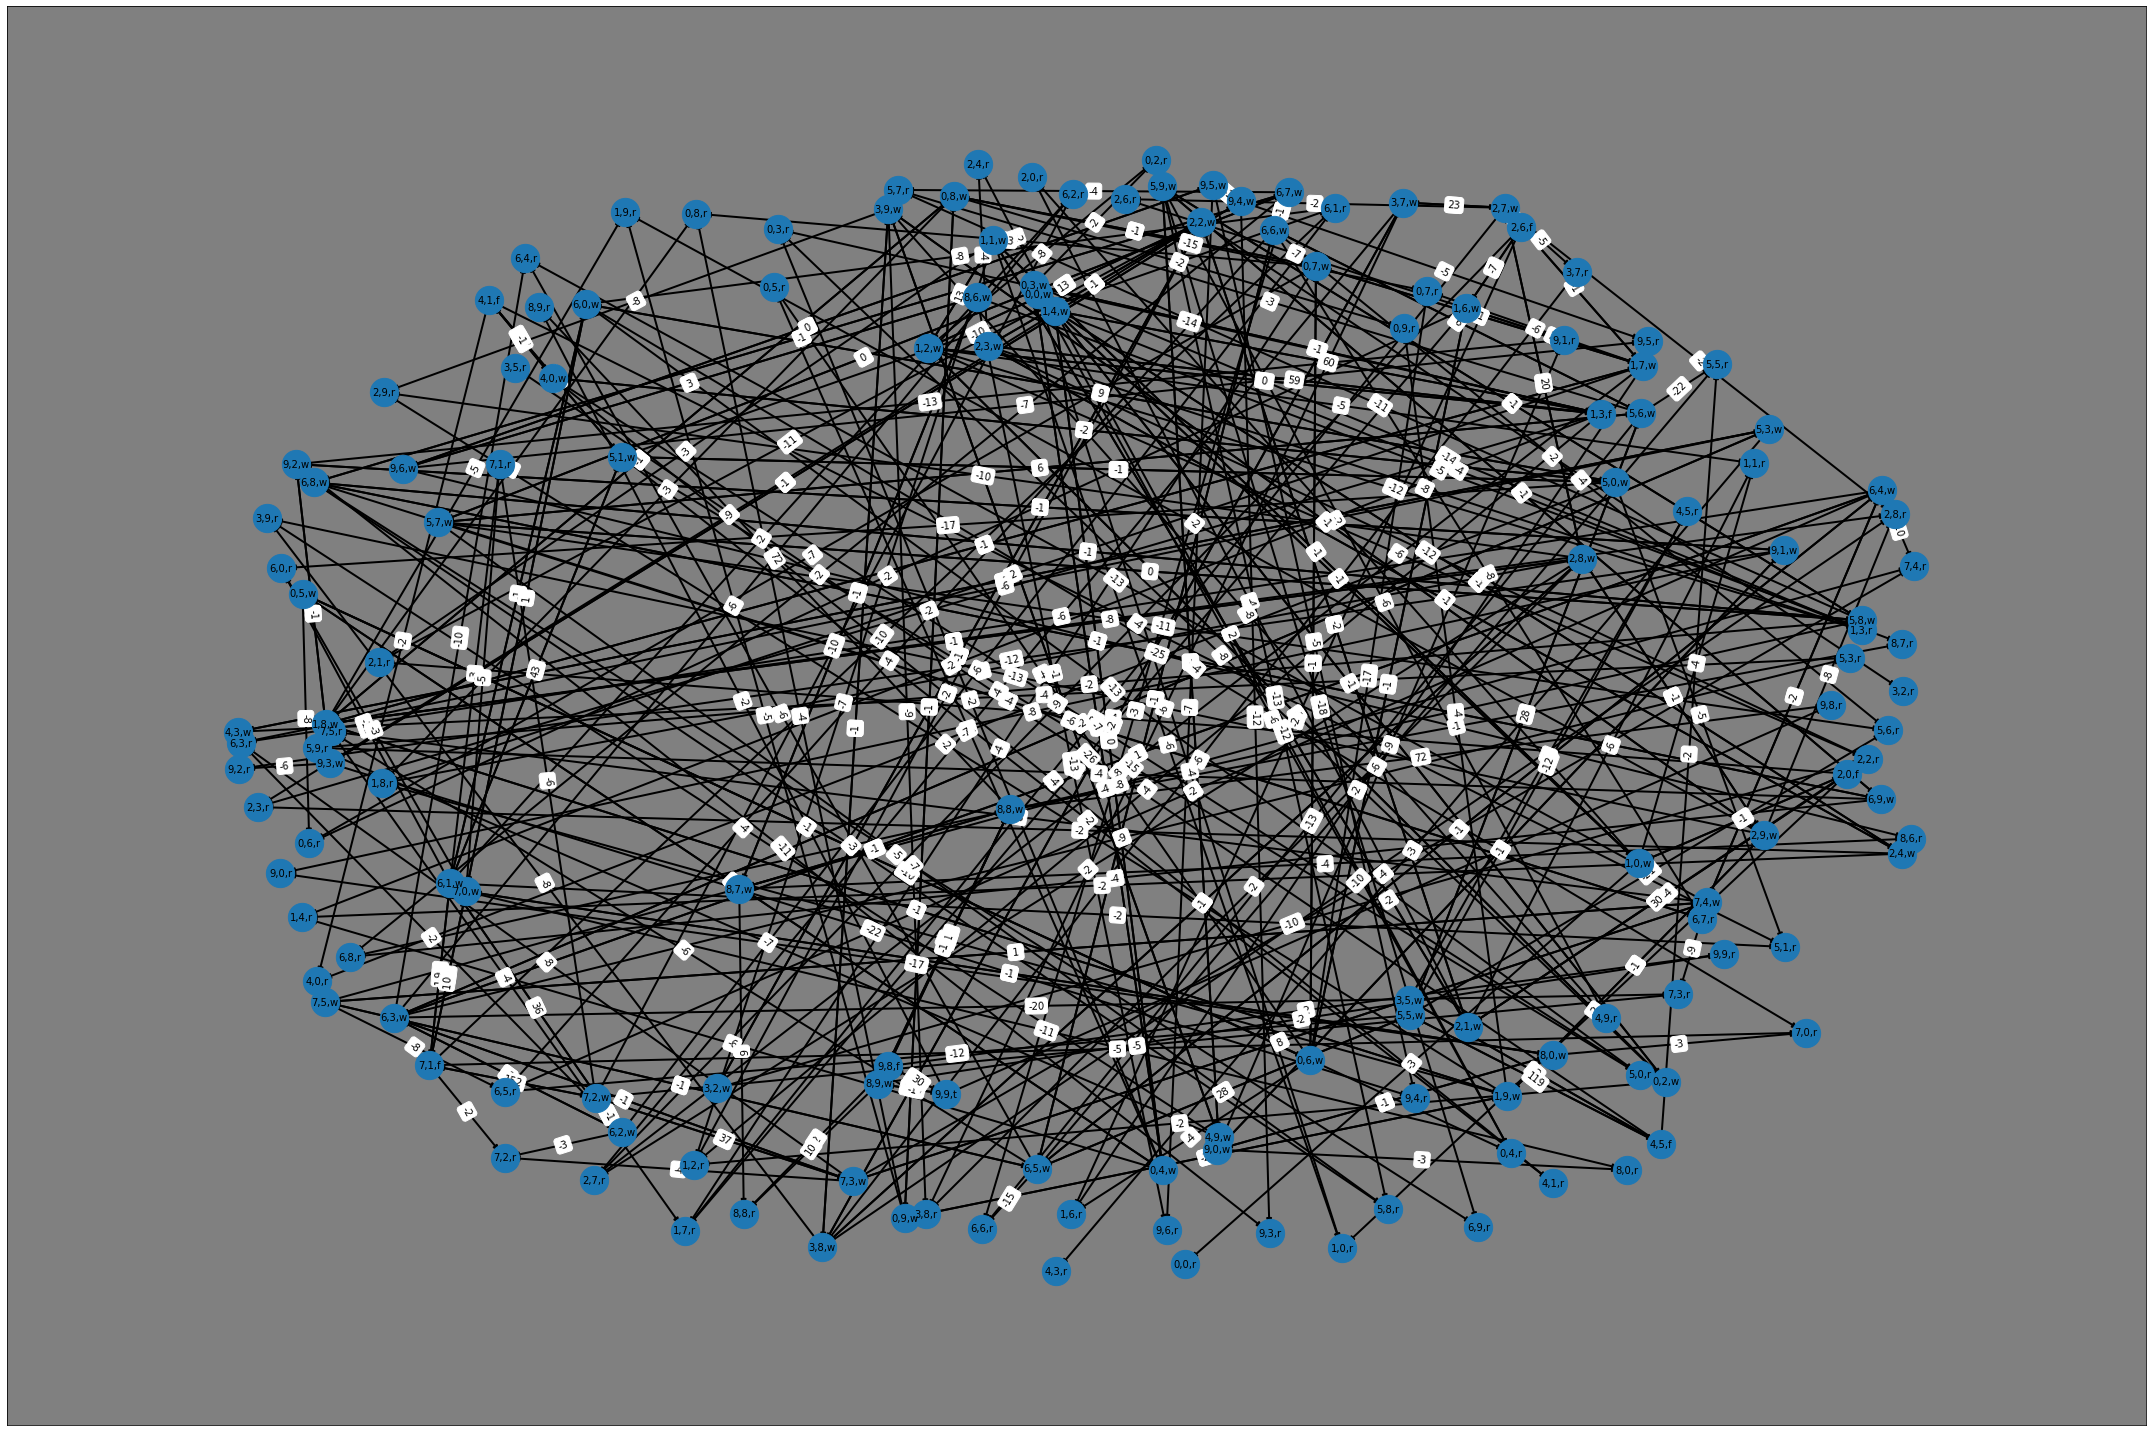

In [54]:
plot_q_table_graph()

In [45]:
print_q_table()

╒═════╤══════╤═════════╤════════╤═════════════╕
│   i │    j │ right   │ left   │          up │
╞═════╪══════╪═════════╪════════╪═════════════╡
│   0 │    0 │ down    │ w      │   6.47626   │
├─────┼──────┼─────────┼────────┼─────────────┤
│   0 │    0 │ down    │ r      │  -6.64781   │
├─────┼──────┼─────────┼────────┼─────────────┤
│   0 │    2 │ down    │ w      │  -1.57945   │
├─────┼──────┼─────────┼────────┼─────────────┤
│   0 │    2 │ down    │ r      │ -13.2865    │
├─────┼──────┼─────────┼────────┼─────────────┤
│   0 │    2 │ right   │ w      │  -1.53946   │
├─────┼──────┼─────────┼────────┼─────────────┤
│   0 │    2 │ right   │ r      │  -6.58727   │
├─────┼──────┼─────────┼────────┼─────────────┤
│   0 │    3 │ down    │ f      │  59.8421    │
├─────┼──────┼─────────┼────────┼─────────────┤
│   0 │    3 │ down    │ r      │  -4.3619    │
├─────┼──────┼─────────┼────────┼─────────────┤
│   0 │    3 │ left    │ w      │  -1.39486   │
├─────┼──────┼─────────┼────────┼───────

In [67]:
EPISODS = 600
GAMMA = 0.25
ALPHA = 1.1
learn()
run()

the last step: 8 8
number of visited flags: 6


In [69]:
EPISODS = 600
GAMMA = 0.5
ALPHA = 0.8
learn()
run()

the last step: 8 8
number of visited flags: 6


In [55]:
EPISODS = 600
GAMMA = 0.5
ALPHA = 1
learn()
print('============================================')
run()

step: 1
0 0 down w

step: 2
1 0 down f

step: 3
2 0 right w

step: 4
2 1 up w

step: 5
1 1 right w

step: 6
1 2 right f

step: 7
1 3 right w

step: 8
1 4 up w

step: 9
0 4 right w

step: 10
0 5 right w

step: 11
0 6 down w

step: 12
1 6 down f

step: 13
2 6 right w

step: 14
2 7 right w

step: 15
2 8 right w

step: 16
2 9 down w

step: 17
3 9 down w

step: 18
4 9 down w

step: 19
5 9 left w

step: 20
5 8 left w

step: 21
5 7 left w

step: 22
5 6 left w

step: 23
5 5 up f

step: 24
4 5 down r

step: 25
5 5 down w

step: 26
6 5 left w

step: 27
6 4 left w

step: 28
6 3 down w

step: 29
7 3 left w

step: 30
7 2 left f

step: 31
7 1 up w

step: 32
6 1 up w

step: 33
5 1 up f

step: 34
4 1 left w

step: 35
4 0 down w

step: 36
5 0 down w

step: 37
6 0 down w

step: 38
7 0 down w

step: 39
8 0 down w

step: 40
9 0 right w

step: 41
9 1 right w

step: 42
9 2 right w

step: 43
9 3 right w

step: 44
9 4 right w

step: 45
9 5 right w

step: 46
9 6 up w

step: 47
8 6 right w

step: 48
8 7 right w

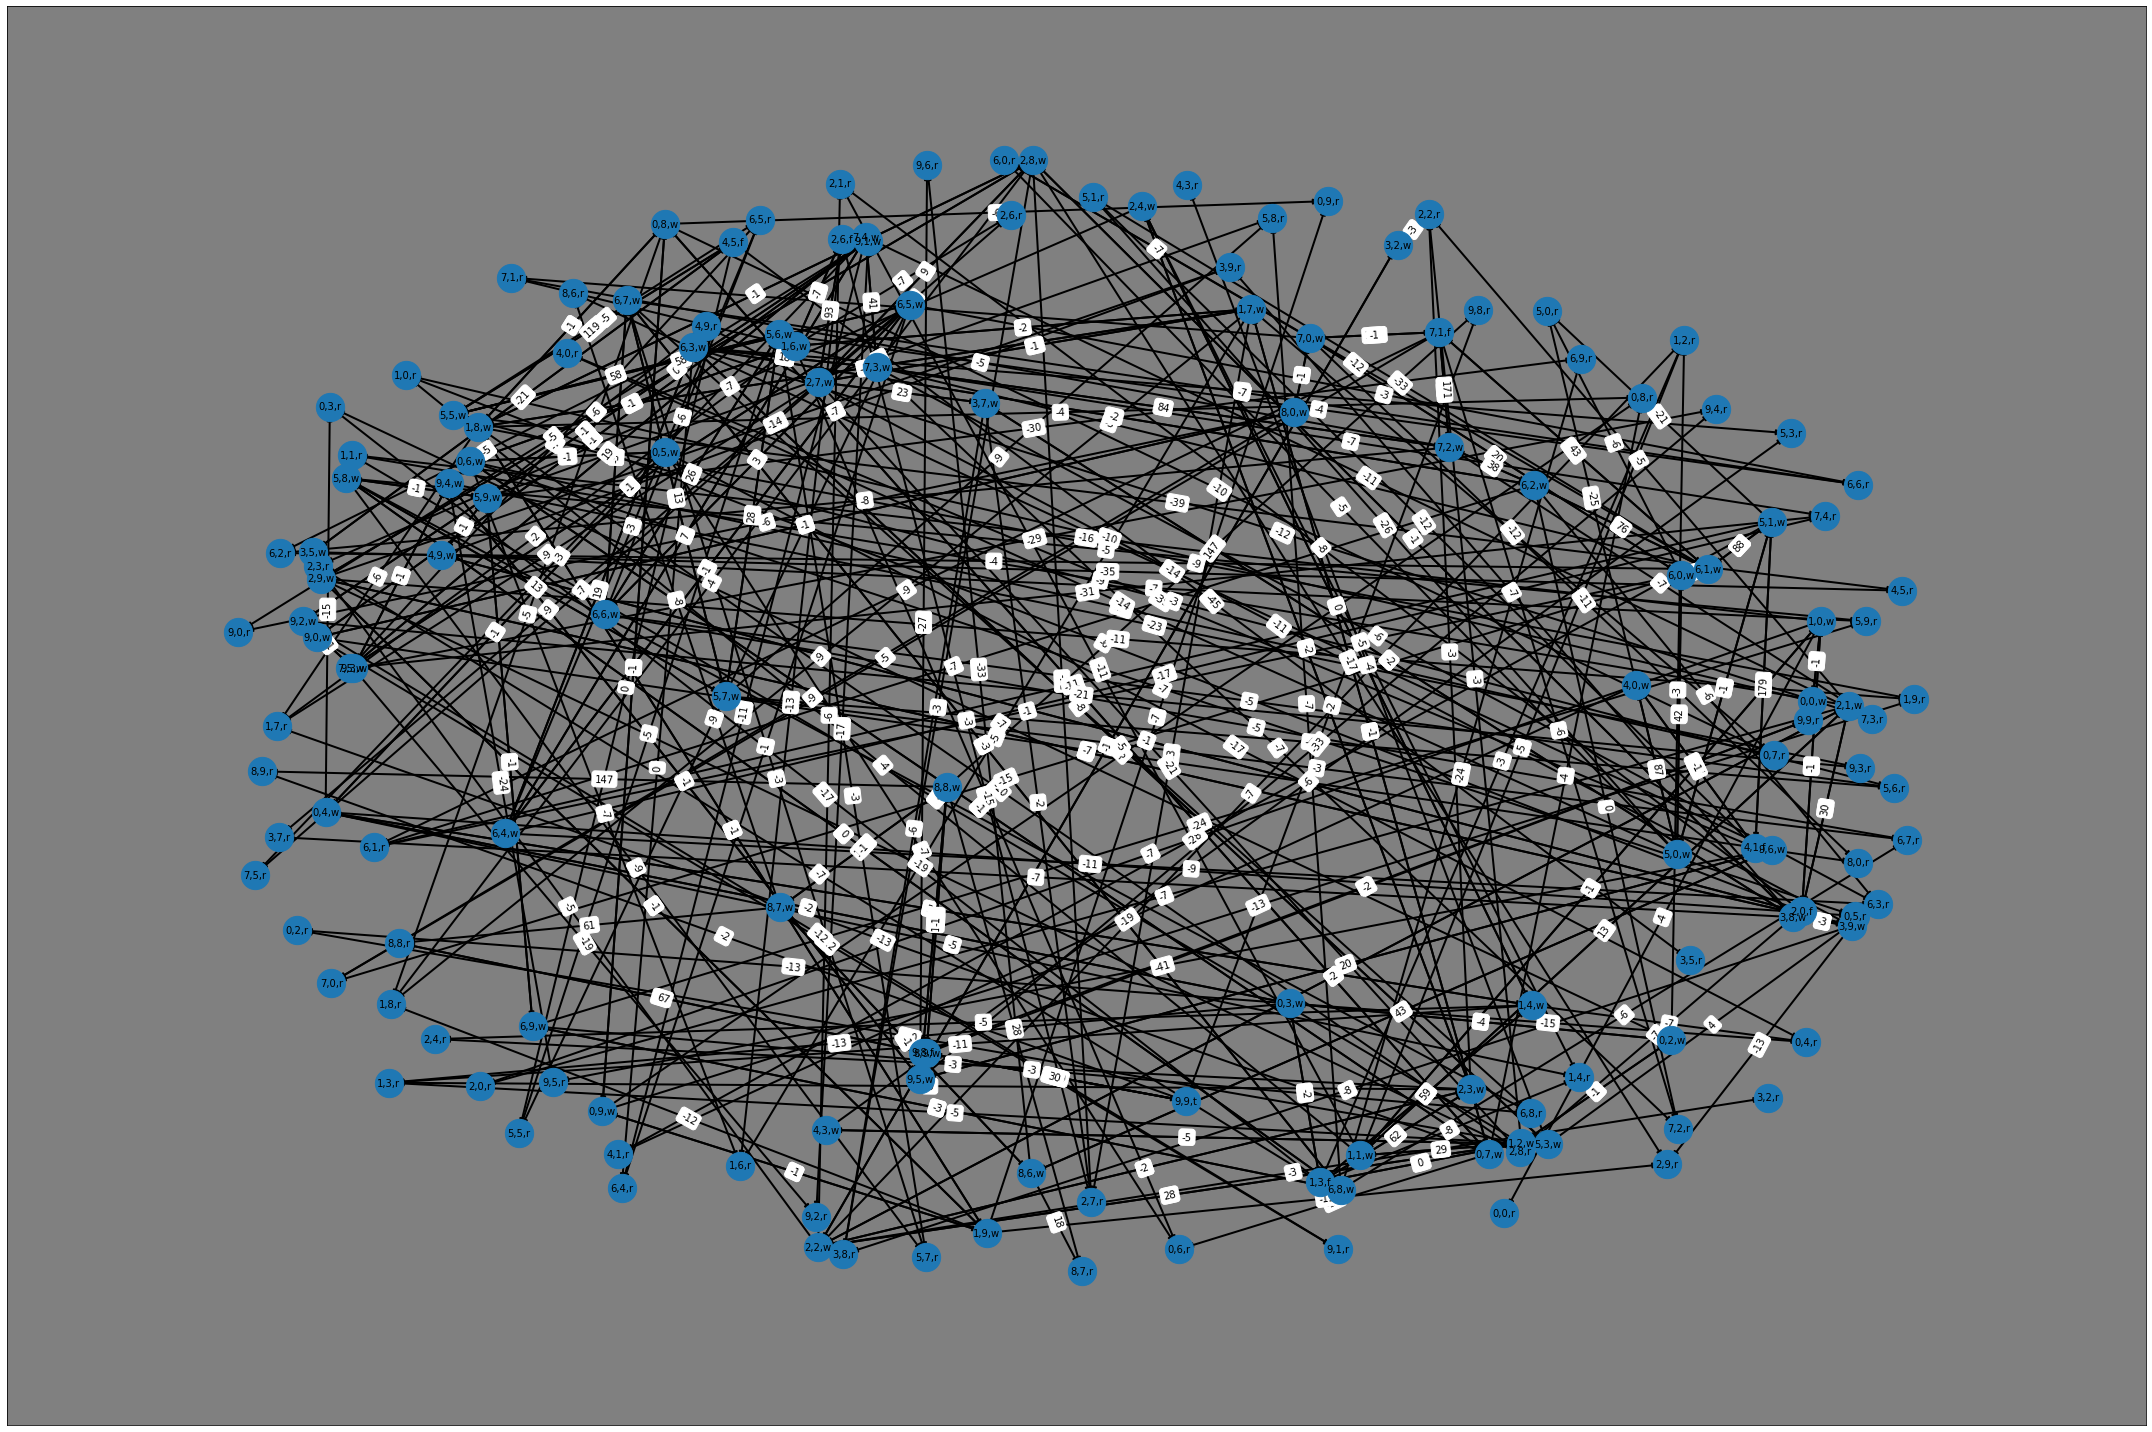

In [56]:
plot_q_table_graph()

In [ ]:
print_q_table()

╒═════╤══════╤═════════╤════════╤═════════════╕
│   i │    j │ right   │ left   │          up │
╞═════╪══════╪═════════╪════════╪═════════════╡
│   0 │    0 │ down    │ w      │   4.15899   │
├─────┼──────┼─────────┼────────┼─────────────┤
│   0 │    0 │ down    │ r      │ -13.8432    │
├─────┼──────┼─────────┼────────┼─────────────┤
│   0 │    2 │ down    │ w      │  -1.33862   │
├─────┼──────┼─────────┼────────┼─────────────┤
│   0 │    2 │ down    │ r      │ -14.3848    │
├─────┼──────┼─────────┼────────┼─────────────┤
│   0 │    2 │ right   │ w      │  -6.11804   │
├─────┼──────┼─────────┼────────┼─────────────┤
│   0 │    2 │ right   │ r      │ -13.2214    │
├─────┼──────┼─────────┼────────┼─────────────┤
│   0 │    3 │ down    │ f      │  46.8185    │
├─────┼──────┼─────────┼────────┼─────────────┤
│   0 │    3 │ down    │ r      │ -23.4033    │
├─────┼──────┼─────────┼────────┼─────────────┤
│   0 │    3 │ left    │ w      │  -8.60237   │
├─────┼──────┼─────────┼────────┼───────

plot_q_table_graph()

In [57]:
EPISODS = 600
GAMMA = 0.5
ALPHA = 1.1
learn()
print('============================================')
run()

step: 1
0 0 down w

step: 2
1 0 down f

step: 3
2 0 right w

step: 4
2 1 right w

step: 5
2 2 right w

step: 6
2 3 up f

step: 7
1 3 up w

step: 8
0 3 right w

step: 9
0 4 right w

step: 10
0 5 right w

step: 11
0 6 down w

step: 12
1 6 down f

step: 13
2 6 right w

step: 14
2 7 down w

step: 15
3 7 right w

step: 16
3 8 right w

step: 17
3 9 down w

step: 18
4 9 down w

step: 19
5 9 left w

step: 20
5 8 left w

step: 21
5 7 left w

step: 22
5 6 left w

step: 23
5 5 up f

step: 24
4 5 down r

step: 25
5 5 down w

step: 26
6 5 down w

step: 27
7 5 left w

step: 28
7 4 left w

step: 29
7 3 left w

step: 30
7 2 left f

step: 31
7 1 up w

step: 32
6 1 up w

step: 33
5 1 up f

step: 34
4 1 left w

step: 35
4 0 down w

step: 36
5 0 down w

step: 37
6 0 down w

step: 38
7 0 down w

step: 39
8 0 down w

step: 40
9 0 right w

step: 41
9 1 right w

step: 42
9 2 right w

step: 43
9 3 right w

step: 44
9 4 right w

step: 45
9 5 right w

step: 46
9 6 up w

step: 47
8 6 right w

step: 48
8 7 right w

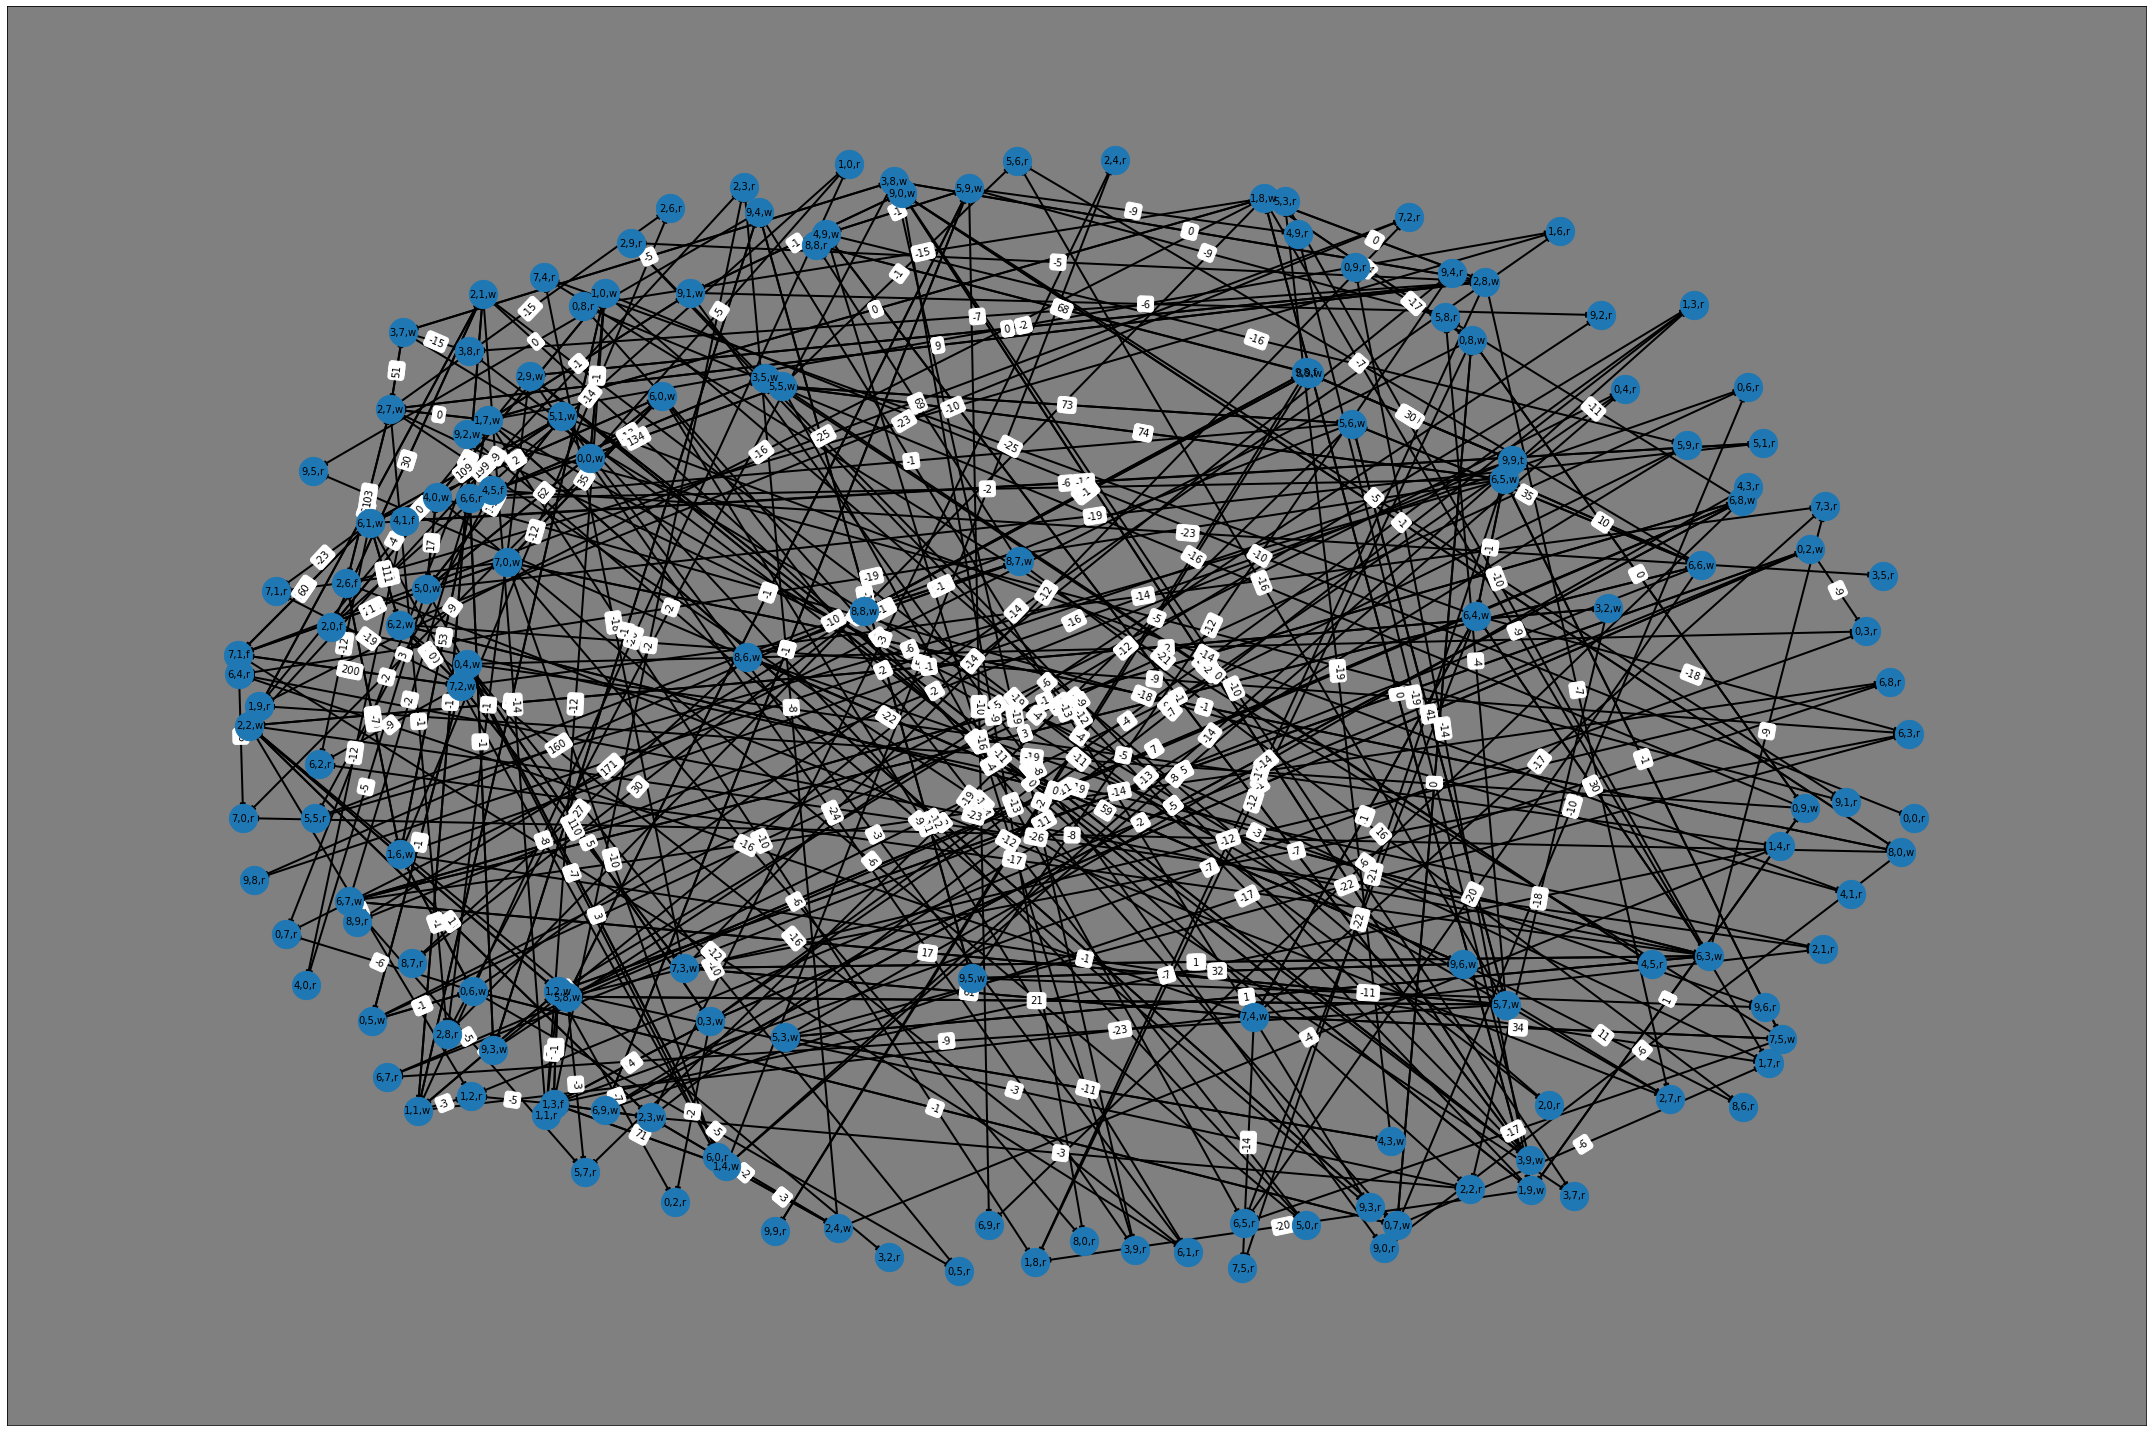

In [59]:
plot_q_table_graph()

In [58]:
print_q_table()

╒═════╤══════╤═════════╤════════╤═════════════╕
│   i │    j │ right   │ left   │          up │
╞═════╪══════╪═════════╪════════╪═════════════╡
│   0 │    0 │ down    │ w      │  22.6705    │
├─────┼──────┼─────────┼────────┼─────────────┤
│   0 │    0 │ down    │ r      │  -5.23589   │
├─────┼──────┼─────────┼────────┼─────────────┤
│   0 │    2 │ down    │ w      │  -1.54373   │
├─────┼──────┼─────────┼────────┼─────────────┤
│   0 │    2 │ down    │ r      │  -2.64373   │
├─────┼──────┼─────────┼────────┼─────────────┤
│   0 │    2 │ right   │ w      │   1.16984   │
├─────┼──────┼─────────┼────────┼─────────────┤
│   0 │    2 │ right   │ r      │  -9.45373   │
├─────┼──────┼─────────┼────────┼─────────────┤
│   0 │    3 │ down    │ f      │  67.8384    │
├─────┼──────┼─────────┼────────┼─────────────┤
│   0 │    3 │ down    │ r      │  -5.43601   │
├─────┼──────┼─────────┼────────┼─────────────┤
│   0 │    3 │ left    │ w      │  -1.34832   │
├─────┼──────┼─────────┼────────┼───────

In [70]:
EPISODS = 600
GAMMA = 1
ALPHA = 0.8
learn()
run()

9 9
the last step: 9 9
number of visited flags: 6


In [79]:
EPISODS = 600
GAMMA = 1
ALPHA = 1
learn()
run()

the last step: 5 1
number of visited flags: 5


In [84]:
EPISODS = 600
GAMMA = 1
ALPHA = 1.1
learn()
run()

the last step: 9 7
number of visited flags: 6


### another envinment:

In [ ]:
BOARD = [['w', 'w', 'f', 'b', 'f'],
         ['w', 'w', 'w', 'w', 'w'],
         ['b', 'b', 'f', 'b', 'w'],
         ['w', 'w', 'b', 'w' ,'w'],
         ['w', 'w', 'w' ,'w' ,'w'],
         ['w', 'w', 'w', 'b', 't']
         ]
EPISODS = 300
GAMMA = 0.5
ALPHA = 1

initialization_q_table()

learn()
print('============================================')
run()

episode 0 :
 explotation:
episode 1 :
 explotation:
exploration
0 0 down
episode 2 :
 explotation:
exploration
0 0 right
0 1 left
episode 3 :
 explotation:
exploration
0 0 right
0 1 down
1 1 right
episode 4 :
 explotation:
exploration
0 0 right
0 1 down
1 1 right
1 2 up
episode 5 :
 explotation:
0 0 right
exploration
0 1 right
0 2 left
0 1 down
1 1 right
episode 6 :
 explotation:
0 0 right
exploration
0 1 right
0 2 down
1 2 left
1 1 left
1 0 up
episode 7 :
 explotation:
0 0 right
exploration
0 1 right
0 2 down
1 2 left
1 1 left
1 0 up
0 0 right
episode 8 :
 explotation:
0 0 right
exploration
0 1 right
0 2 down
1 2 right
1 3 left
1 2 right
1 3 right
1 4 up
episode 9 :
 explotation:
0 0 right
exploration
0 1 right
0 2 down
1 2 up
0 2 left
0 1 down
1 1 right
1 2 up
0 2 down
episode 10 :
 explotation:
0 0 right
0 1 right
exploration
0 2 down
1 2 left
1 1 up
0 1 left
0 0 right
0 1 right
0 2 down
1 2 right
episode 11 :
 explotation:
0 0 right
0 1 right
exploration
0 2 down
1 2 up
0 2 left
0 